# Deep Q-Learning
 Applying the Deep Q-learning algorithm using PyTorch and OpenAI Gym.
 
 [Reference](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
 
 FOLLOW:
 [REFERENCE UDACITY](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn)

## Environment - CartPole-v1

This is a classic control problem implemented in the Gym package. From the docs: 

>A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

An example of the final control achieved is shown below.

![CartPole Gif](https://github.com/Fernandohf/Reinforcement-Learning/blob/master/gym/results/result.gif?raw=true)

Import relevant packages:
- **Gym**: Load environment.
- **Numpy**: Efficient matricial operations.
- **PyTorch**: Deep learning framework.
- **Seaborn**: Visualization.

In [1]:
import gym
from collections import deque
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

Create the environment and get the states bounds.

In [2]:
# Create GYM environment
env = gym.make("CartPole-v1")

## Create the Fully Connected Network



In [16]:
class DQN(nn.Module):
    """
    Class of the deep fully conected network.
    """
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 256, bias=False)
        self.dropout = nn.Dropout(.5)
        self.fc2 = nn.Linear(256, 64, bias=False)
        self.fc3 = nn.Linear(64, outputs)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = F.relu(self.fc3(x))
        
        return x

## Memory Class

In [10]:
class Memory():
    """
    Class responsible to keep the Memory buffer
    """
    def __init__(self, max_size):
        """
        Creates the object
        
        Input:
        max_size: Max number os experiences saved
        
        """
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        """
        Add an expericende tuple to memory
        
        Inputs: 
            experience: Tuple with all experience information
        """
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """
        Random sample from the memory
        
        Input:
            batch_size: Sample size
        
        """
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [11]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TOTAL_EPISODES = 32* 100
MAX_STEPS = 200
MEMORY_SIZE = 10000
MEMORY_FILLER = 100

In [12]:
# Look for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Traning on {device}")

Traning on cpu


In [13]:
# Number of actions and states
action_size = env.action_space.n
print(action_size)

2


In [14]:
# Observation bounds
obs_size = len(env.observation_space.sample())
print(obs_size)

4


In [17]:
# DQN Model
model = DQN(obs_size, action_size).to(device)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Criterion
criterion = nn.SmoothL1Loss()

In [20]:
memory = Memory(MEMORY_SIZE)

In [21]:
# Instantiate memory
def init_memory(memory, episodes_fill=100, max_steps=200):
    for episode in range(episodes_fill):
        # Reset the environment
        state = env.reset()
        done = False
        total_rewards = 0

        for step in range(max_steps):
            # Choose random action a in the current world state (s)
            action = env.action_space.sample()

            # Take the action and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)
            
            # Add experience to memory
            memory.add((state, action, reward, new_state, done))
            
            # Define state
            state = new_state
            # If the episode is finished
            if done:
                break
            

In [22]:
init_memory(memory)

## Training Loop

In [23]:
# For life or until learning is stopped
epsilon = EPS_START
losses = []
for episode in tqdm_notebook(range(TOTAL_EPISODES)):
    # Reset the environment
    state = env.reset()

    step = 0
    done = False
    total_rewards = 0
    
    for step in range(MAX_STEPS):
        ## First we randomize a number
        exp_exp_tradeoff = np.random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation
        if exp_exp_tradeoff > epsilon:
            with torch.no_grad():
                # Pick action with the larger expected reward.
                state_tensor = torch.from_numpy(state).view(1, -1).to(device).float()
                action_tensor = torch.argmax(model(state_tensor), dim=1)
                action = action_tensor.cpu().numpy().squeeze()
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        
        # Store transition <st,at,rt+1,st+1> in memory D
        memory.add((state, action, reward, new_state, done))
                
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
    # Empty acumulated gradients
    optimizer.zero_grad()
    
    # Get the batch from memory
    batch = memory.sample(BATCH_SIZE)
    rewards = np.array([each[2] for each in batch])
    states_mb = np.array([each[0] for each in batch])
    actions_mb = np.array([each[1] for each in batch])
    rewards_mb = np.array([each[2] for each in batch]) 
    new_states_mb = np.array([each[3] for each in batch])
    dones_mb = np.array([each[4] for each in batch])

    target_Qs_batch = []

    # Get Q values for next_state
    Qs_new_state = model(torch.from_numpy(new_states_mb).to(device).float())
    # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
    for i in range(0, len(batch)):
        terminal = dones_mb[i]

        # If we are in a terminal state, only equals reward
        if terminal:
            target_Qs_batch.append(rewards_mb[i])

        else:
            target = (torch.tensor(rewards_mb[i]) +
                      torch.tensor(GAMMA) * torch.max(Qs_new_state[i]))
            target_Qs_batch.append(target)

    # Target scores
    targets_mb = torch.tensor([each for each in target_Qs_batch]).to(device)
    model_pred = model(torch.from_numpy(states_mb).to(device).float())
    
    # Get max q-values
    q_pred = torch.max(model_pred, dim=1)[0]
    
    loss = criterion(q_pred.float(), targets_mb.float())
    loss.backward()
    optimizer.step()
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-EPS_DECAY * episode) 
    
    # Saves loss
    losses.append(loss.item())

Here, we create the q-table with the dimensions corresponding to each state variable discretization bucket and actions. Additionally, the hyperparameters are selected:

- *Episodes*: Total number of episodes to fill q-table.
- *Learning Rate*: Learning rate used in Bellman's Equation.
- *Max Steps*: Max number of steps in each episode.
- *Gamma*: Discounting rate for old rewards.
- *Epsilon*: Initial Epsilon value, close to 1 represents exploration.
- *Decay Rate*: Rate to reduce Epsilon value.


## Results

Using the highest reward for each state on **Q-Table**, we can estimate the best action. The code below executes the simulation following the optimal actions trained.

In [1]:
# Show final results
# Wrapper to save  as video
menv = gym.wrappers.Monitor(env, "results", force=True) # Uncomment to save video
# menv = env
for episode in range(3):
    states = menv.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)
    for step in range(250):
        
        # Take the action (index) that have the maximum expected future reward given that state
        state_tensor = torch.from_numpy(states).view(1, -1).to(device).float()
        action_tensor = torch.argmax(model(state_tensor), dim=1)
        action = action_tensor.cpu().numpy().squeeze()

        new_state, reward, done, info = menv.step(action)
        menv.render()
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
    else:
        menv.close()


NameError: name 'gym' is not defined

## Reward Evolution

The graph shows how the mean reward evolves during the Q-Table filling phase.

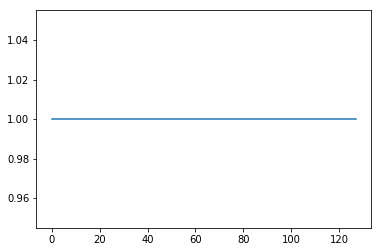

In [24]:
# Rewards
sns.lineplot(range(len(rewards)), rewards)

## Epsilon Decay

How the epsilon value decays with the number of epsiodes.

In [25]:
# Rewards
x = np.arange(1, total_episodes)
y = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*x) 
sns.lineplot(x, y)

NameError: name 'total_episodes' is not defined